## Load necessary modules

In [2]:
!pip install sklearn_pandas

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import itertools
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn_pandas import (
    DataFrameMapper, 
    FunctionTransformer
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

## Load necessary data

In [5]:
iris = load_iris()
X = iris["data"]
y = iris["target"]
feature_names = [col.replace(" ", "_").replace("_(cm)", "") 
                 for col in (iris["feature_names"] + ["species"])]
class_names = {0.0: "setosa", 1.0: "versicolor", 2.0: "virginica"}

# convert to data frame purely for showing the data
iris_df = pd.DataFrame(np.column_stack((X, y.reshape(-1, 1)))
                       , columns=feature_names)

# convert species from numeric to categorical
iris_df["species"] = iris_df["species"].map(class_names)

iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### For educational purposes only, let's replace some values with `NaN`

In [6]:
# initialize random number generator
random.seed(2019)

# generate list of random integers 
random_ints = [random.randrange(0, len(iris_df)) for _ in range(20)]

# for these random index values, replace their real values with NaN
iris_df.loc[random_ints, "sepal_length"] = np.nan
iris_df.loc[random_ints, "sepal_width"] = np.nan

# manually force the first "sepal_width" value to also be NaN
iris_df.loc[0, "sepal_width"] = np.nan

iris_df.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,NaN,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,NaN,NaN,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


## Create function to identify records that have `NaN` values

This will help us pick up on whether or not having a `NaN` value is helpful information in our model

In [7]:
def is_missing(x):
    """IDs records that contain missing (NaN) values"""
    if pd.isna(x):
        return 1
    else:
        return 0

## Do not create an object that imputes median values

Unfortunately, `sklearn_pandas` is still under development. The usage of the following:

```python
impute_median = SimpleImputer(missing_values=np.nan, strategy="median")
```

inside `DataFrameMapper` will result in all columns that use the `impute_median` transformer to have the same value.

Instead, do a gut check by manually printing out the median values.

In [8]:
print(f"Median value for sepal length: {iris_df['sepal_length'].median()}")
print(f"Median value for sepal width: {iris_df['sepal_width'].median()}")

Median value for sepal length: 5.75
Median value for sepal width: 3.0


## Store preprocessing steps in one object

![kid transformer](visuals/transformer.gif)

We'll store these steps in a `DataFrameMapper` object. A `DataFrameMapper` maps `pandas` data frame column subsets to their own transformations. This is abstraction is useful since we'll always be applying the same preprocessing steps to both our training and testing sets.

The key here is we need to specify a specific column, pass it's "transformer" (i.e. `SimpleImputer`, `OneHotEncoder`, `StandardScaler`), and determinie if the transformation belongs in it's own new column or if it's more appropriate for the transformed column to overwrite the input column.

Here, we'll create `mapper` object to do the following:

* flag which records contain `NaN` values in the `sepal_length` feature;
* impute the median value for `NaN` values in the `sepal_length` feature;
* flag which records contain `NaN` values in the `sepal_width` feature;
* impute the median value for `NaN` values in the `sepal_width` feature; and
* return all other columns - `petal_length` & `petal_width` - as is.


In [9]:
mapper = DataFrameMapper(features=[
    (["sepal_length"], FunctionTransformer(is_missing), {"alias": "sepal_length_missing"}),
    (["sepal_length"], SimpleImputer(missing_values=np.nan, strategy="median")),
    (["sepal_width"], FunctionTransformer(is_missing), {"alias": "sepal_width_missing"}),
    (["sepal_width"], SimpleImputer(missing_values=np.nan, strategy="median")),
],
                         default=None,
                         df_out=True)

In [10]:
# just like a model object, 
# we'll fit and transform the DataFrameMapper object onto our data
mapper.fit(iris_df).transform(iris_df).head(10)

,sepal_length_missing,sepal_length,sepal_width_missing,sepal_width,petal_length,petal_width,species
0,0,5.10,1,3.0,1.4,0.2,setosa
1,0,4.90,0,3.0,1.4,0.2,setosa
2,0,4.70,0,3.2,1.3,0.2,setosa
3,0,4.60,0,3.1,1.5,0.2,setosa
4,0,5.00,0,3.6,1.4,0.2,setosa
5,0,5.40,0,3.9,1.7,0.4,setosa
6,0,4.60,0,3.4,1.4,0.3,setosa
7,0,5.00,0,3.4,1.5,0.2,setosa
8,1,5.75,1,3.0,1.4,0.2,setosa
9,0,4.90,0,3.1,1.5,0.1,setosa


Notice how the 9th record in both columns contains a value of `1`. This algins with the output of `iris_df.head(10)`, with both values in `sepal_length` and `sepal_width` containing `NaN` values.

The use of our custom function was honored and bug-free, as only the first record in `sepal_width_missing` has a value of `1` and `sepal_length_missing` has a value of `0`.

All records in the `petal_length`, `petal_width` and `species` columns are returned with no transformation.

## Now let's take this up a level by performing `train_test_split` before any preprocessing and build a `DecisionTreeClassifier` model to classify which species a flower is

In [11]:
# split data 
X_train, X_test, y_train, y_test = train_test_split(iris_df.drop("species", axis=1),
                                                    iris_df["species"],
                                                    test_size=0.3,
                                                    random_state=2019)

In [12]:
# build classifier
dt_clf = DecisionTreeClassifier(random_state=2019,
                                min_samples_leaf=30,
                                criterion="gini",
                                min_samples_split=2)

In [15]:
# build pipeline
pipe = Pipeline(steps=[
    ("dataprep", mapper),
    ("model", dt_clf)
])

Fit `X_train` and `y_train` onto the `pipe` object

In [16]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('dataprep',
                 DataFrameMapper(default=None, df_out=True,
                                 features=[(['sepal_length'],
                                            FunctionTransformer(func=None),
                                            {'alias': 'sepal_length_missing'}),
                                           (['sepal_length'],
                                            SimpleImputer(add_indicator=False,
                                                          copy=True,
                                                          fill_value=None,
                                                          missing_values=nan,
                                                          strategy='median',
                                                          verbose=0)),
                                           (['sepal_width'],
                                            FunctionTransformer(func=None),
                       

Use the `pipe` object to make predictions on `X_test`

In [17]:
y_pred = pipe.predict(X_test)

Examine the first 10 predictions of our multi-class classifier!

In [18]:
y_pred[0:10]

array(['setosa', 'setosa', 'virginica', 'versicolor', 'virginica',
       'setosa', 'virginica', 'setosa', 'versicolor', 'virginica'],
      dtype=object)

Compare with `y_test`

In [19]:
y_test[0:10]

42         setosa
20         setosa
124     virginica
87     versicolor
107     virginica
40         setosa
111     virginica
46         setosa
84     versicolor
147     virginica
Name: species, dtype: object

## TODO

* Make multi class ROC Curve: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

## Let's get a general sense of accuracy

* revist the accuracy score
* introduce the confusion matrix
    + Precision
    + Recall
    + F1 Score
* introduce the ROC curve and AUC

## Let's create a confusion matrix to visualize where our model messed up

> [A] confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one. - [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix)

In [20]:
# create confusion matrix
# tn, fp, fn, tp
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[19,  0,  0],
       [ 0,  9,  1],
       [ 0,  1, 15]])

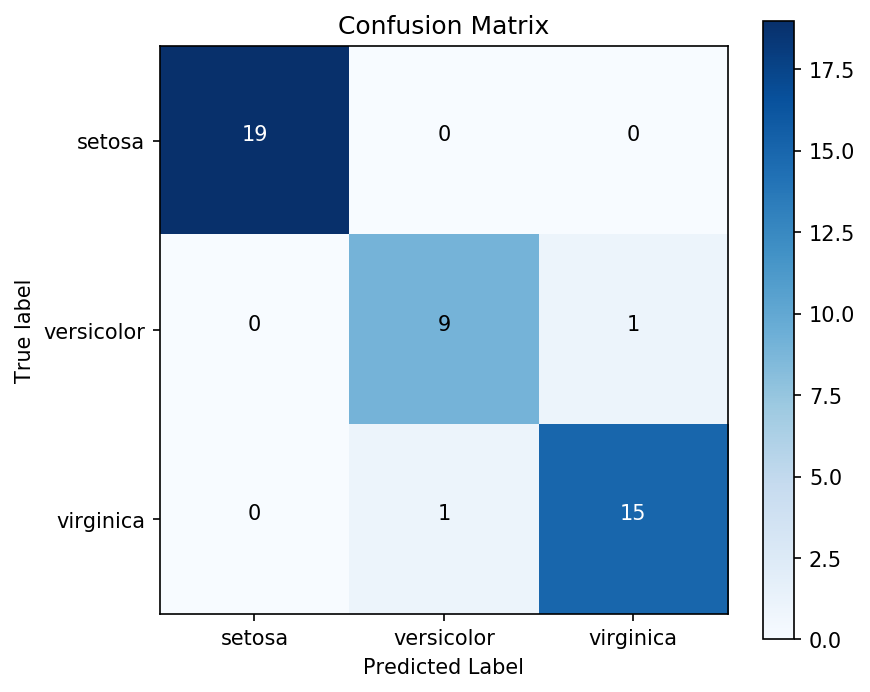

In [21]:
# build confusion matrix plot
plt.figure(figsize=(6, 5), dpi=150)
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

# Add title and Axis Labels
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted Label")

# add axis labels
tick_marks = [val for val in class_names.keys()]
plt.xticks(tick_marks, class_names.values())
plt.yticks(tick_marks, class_names.values())

# Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        plt.text(i, j, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

# Add a Side Bar Legend Showing Colors
plt.colorbar()

# Add padding
plt.tight_layout()

# save plot
plt.savefig("visuals/multi_class_conf_matrix.png",
            dpi=150,
            bbox_inches="tight")

# display plot
plt.show()

## Using the confusion matrix to evaluate our classifier

### Accuracy

Accuracy is the percentage of times that your model predicted correctly.

Accuracy = correct predictions / total predictions


$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

In [22]:
# manual method
correct_preds = 19 + 9 + 15
total_preds = correct_preds + (1 + 1)
print(f"Accuracy score of {correct_preds / total_preds}")

Accuracy score of 0.9555555555555556


In [23]:
# using sklearn.metrics method
print(f"Accuracy score of {accuracy_score(y_test, y_pred)}")

Accuracy score of 0.9555555555555556


### Precision

Of all the times your model predicted 1, how often was it correct?

Precision = correct 1 predictions / correct 1 prediction + incorrect 1 prediction

$$ Precision = \frac{TP}{TP + FP} $$


In [24]:
# manual method
precision = {"setosa": 19 / (19 + 0),
             "versicolor": 9 / (9 + 1),
             "virginica": 15 / (15 + 1)}

for key, val in precision.items():
    print(f"The precision score for {key} is {val}")

The precision score for setosa is 1.0
The precision score for versicolor is 0.9
The precision score for virginica is 0.9375


In [25]:
# using sklearn.metrics method
# note: if the classifier was binary, we would leave 'average' set to 'binary'
#       since this is a multi-class, we'll set the 'average' to None so we can get the precision score for each class
for key, val in zip(precision.keys(), precision_score(y_test, y_pred, average=None)):
    print(f"The precision score for {key} is {val}")

The precision score for setosa is 1.0
The precision score for versicolor is 0.9
The precision score for virginica is 0.9375


### Sensitivity aka Recall aka True Positive Rate (TPR)

Sensitivity measures what percentage of (actual) 1’s your model correctly predicted.

recall = correct 1 prediction / (correct 1 predictions + incorrect 0 predictions)

$$ recall = \frac{TP}{TP + FN}$$

In [ ]:
# manual method
recall = {"setosa": 19 / (19 + 0),
          "versicolor": 9 / (9 + 1),
          "virginica": 15 / (15 + 1)}

for key, val in recall.items():
    print(f"The recall score for {key} is {val}")

In [ ]:
# using sklearn.metrics method
# note: if the classifier was binary, we would leave 'average' set to 'binary'
#       since this is a multi-class, we'll set the 'average' to None so we can get the recall score for each class
for key, val in zip(recall.keys(), recall_score(y_test, y_pred, average=None)):
    print(f"The recall score for {key} is {val}")